# Modeling Cross Section Data with Neural Networks

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes.

This notebook uses the EXFOR Dataset and builds a model to predict the cross section of several nuclear reactions. To do this, we'll provide the model with a description of many expeirmentally measrued values. This description includes attributes like: # of neutrons, # of protons, Neutron Separation Energy, and Atomic Mass.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

2.1.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Getting the Data: Cross Sections

In [9]:
print("Reading data into dataframe...")
df = pd.read_csv("../ML_Data/working_xs_v2_unsk.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Target_Meta_State", "MT", "I78", "Product_Meta_State", "Frame", "Reaction_Notation", "Title", 
            "Institute", "Reference", "Out", "Origin", "Element", "Element_w_A", "spin", "parity"]
df[str_cols] = df[str_cols].astype('category')

# Converting remaining columns to numeric type. 
for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)

# Converting proton, neutron and mass number features to integers
int_cols = ["Protons", "Year", "Date", "Target_Neutrons", "Target_Mass_Number", "Compound_Neutrons", "Compound_Mass_Number"]
df[int_cols] = df[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [10]:
df.columns

Index(['Target_Meta_State', 'MT', 'Energy', 'dEnergy', 'Data', 'dData',
       'ELV/HL', 'dELV/HL', 'I78', 'Protons', 'Product_Meta_State', 'Frame',
       'Reaction_Notation', 'Title', 'Year', 'Institute', 'Date', 'Reference',
       'Out', 'Target_Neutrons', 'Origin', 'Mass_Excess', 'dMass_Excess',
       'Binding_Energy', 'dBinding_Energy', 'B_Decay_Energy',
       'dB_Decay_Energy', 'Atomic_Mass_Micro', 'dAtomic_Mass_Micro', 'S(2n)',
       'dS(2n)', 'S(2p)', 'dS(2p)', 'Q(a)', 'dQ(a)', 'Q(2B-)', 'dQ(2B-)',
       'Q(ep)', 'dQ(ep)', 'Q(B-n)', 'dQ(B-n)', 'Target_Mass_Number', 'Element',
       'S(n)', 'dS(n)', 'S(p)', 'dS(p)', 'Q(4B-)', 'dQ(4B-)', 'Q(d,a)',
       'dQ(d,a)', 'Q(p,a)', 'dQ(p,a)', 'Q(n,a)', 'dQ(n,a)', 'Q(g,p)', 'Q(g,n)',
       'Q(g,pn)', 'Q(g,d)', 'Q(g,t)', 'Q(g,He3)', 'Q(g,2p)', 'Q(g,2n)',
       'Q(g,a)', 'Q(p,n)', 'Q(p,2p)', 'Q(p,pn)', 'Q(p,d)', 'Q(p,2n)', 'Q(p,t)',
       'Q(p,3He)', 'Q(n,2p)', 'Q(n,np)', 'Q(n,d)', 'Q(n,2n)', 'Q(n,t)',
       'Q(n,3He)', 'Q(d,t)',

In [11]:
basic_info_cols = ["MT", "Energy", "Data", "Protons", "Target_Neutrons", "Atomic_Mass_Micro", 
                   "Target_Mass_Number", "Nuc_Radius_fm", "Neut_Nuc_Rad_Ratio", "spin", "parity", "Year"]
df = df[basic_info_cols]

In [12]:
df.shape

(4533407, 12)

# One-Hot-Encoding of Categorical Data 

Categorical data can be represented by either assigning a numerical value to each category or by a sparse binary matrix where a `1` is placed when the category is present. We opted for the latter. In this case the categorical features include:

> `MT`: which refers to the ENDF reaction number. 

> `spin`: 

> `parity`

In [13]:
# Specify categorical variables calculating one-hot-encode features 
# The useful categorical feature can also be Out, in this case we use OUT
cat_cols = ["MT", "spin", "parity"]
df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

# Corrections for Bad Measurements

Chlorine (n,p) reaction contains contradictory data between two experimental campagins. I am assuming the newest measruments are correct therefore discarding the oldest measruments.

In [14]:
# df = df[~((df["Protons"] == 17) & (df["Out_P"] == 1) & (df["Target_Mass_Number"] == 35) & (df["Year"] < 1962))]
df = df[~((df["Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35) & (df["Year"] < 1962))]

In [15]:
df = df.drop(columns=["Year"])

In [16]:
df.shape

(4533364, 59)

# Sampling Chlorine (n,p) and (n,g) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [17]:
# # (n,p) reaction (MT=103)
to_plot = df[(df["Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)
# to_plot = df[(df["Protons"] == 17) & (df["Out_P"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)

# # (n,g) reaction (MT=102)
# to_plot2 = df[(df["Protons"] == 17) & (df["Out_G"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)
to_plot2 = df[(df["Protons"] == 17) & (df["MT_102"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)

# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [75]:
new_data = pd.read_csv("./Chlorine_Data/new_cl_np.csv")  

In [76]:
# Adding features to newly measured data
for i in list(to_plot.columns)[2:]:
    new_data[i] = to_plot[i].values[1]

new_data["Energy"] = np.log10(new_data["Energy"])
new_data["dEnergy"] = np.log10(new_data["dEnergy"])
new_data = new_data.drop(columns=["dEnergy", "dData"])

# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [20]:
endf = pd.read_csv("./Chlorine_Data/endf_Cl_np.csv")
endf["Energy"] = np.log10(endf["Energy"])
endf.head()

,Energy,Data
0,6.378527,0.162609
1,6.378917,0.162724
2,6.389669,0.165948
3,6.397940,0.168482
4,6.400994,0.169618


In [21]:
endf_all = pd.read_csv("./Chlorine_Data/endf_Cl_np_all.csv")
endf_all["Energy"] = np.log10(endf_all["Energy"])
endf_all.shape

(8791, 2)

# Visualizing Chlroine (n,p) Data

In [22]:
def plot_exfor_endf(protons, mass_number, mt, endf_data):
    to_plot = df[(df["Protons"] == protons) & (df[mt] == 1) & (df["Target_Mass_Number"] == mass_number)].sort_values(by='Energy', ascending=False)
    plt.figure(figsize=(15,10))
    sns.scatterplot(to_plot["Energy"], to_plot["Data"], alpha=0.5, label="True")
    sns.lineplot(endf_data["Energy"], endf_data["Data"], alpha=0.5, label="ENDF", color='g')
#     sns.lineplot(to_plot["Energy"], to_plot["Data"], alpha=0.5, label="Interpolation")
    sns.scatterplot(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data")
    plt.title('Cl-35(n,p) SIG')
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    plt.yscale('log')
    minimum = to_plot["Data"].min() - to_plot["Data"].min() * 0.2
    maximum = to_plot["Data"].max() + to_plot["Data"].max() * 0.2
    plt.ylim(minimum, maximum)
    plt.legend()

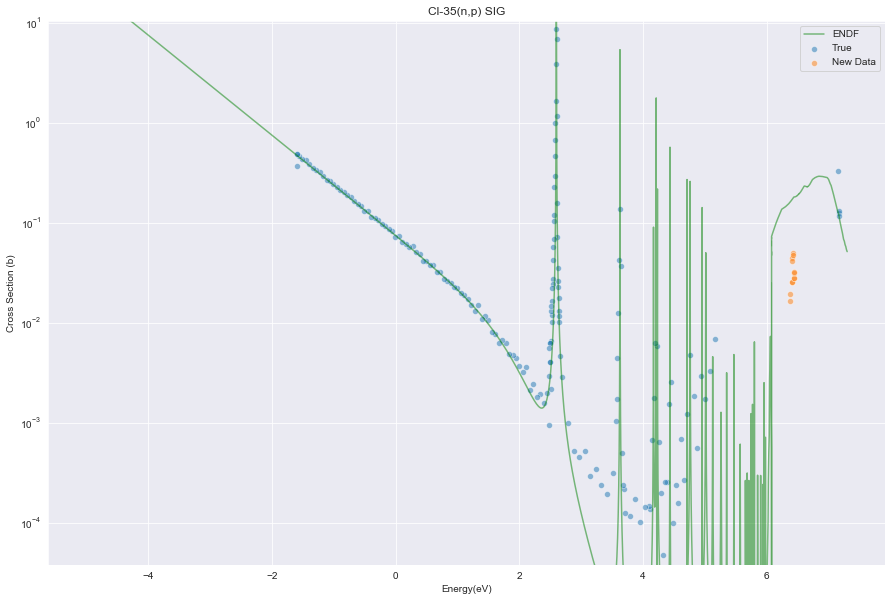

In [23]:
plot_exfor_endf(17, 35, "MT_103", endf_all)

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

# Limiting DataFrame to Specific Ranges

In [25]:
df.shape

(4533364, 59)

In [26]:
df.head()

,Energy,Data,Protons,Target_Neutrons,Atomic_Mass_Micro,Target_Mass_Number,Nuc_Radius_fm,Neut_Nuc_Rad_Ratio,MT_1,MT_2,MT_3,MT_4,MT_16,MT_17,MT_18,MT_22,MT_24,MT_28,MT_29,MT_32,MT_33,MT_37,MT_41,MT_51,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_111,MT_112,MT_113,MT_152,MT_153,MT_155,MT_158,MT_159,MT_160,MT_161,MT_203,spin_0.0,spin_0.5,spin_1.0,spin_1.5,spin_2.0,spin_2.5,spin_3.0,spin_3.5,spin_4.0,spin_4.5,spin_5.0,spin_5.5,spin_6.0,spin_7.0,parity_-1,parity_1
0,7.945469,0.0300,0,1,1.008665e+06,1,1.25,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,7.991669,0.0291,0,1,1.008665e+06,1,1.25,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,8.041393,0.0279,0,1,1.008665e+06,1,1.25,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,8.077731,0.0264,0,1,1.008665e+06,1,1.25,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,8.111934,0.0256,0,1,1.008665e+06,1,1.25,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [27]:
df_less_40 = df[df["Target_Mass_Number"] < 40].sort_values(by='Energy', ascending=True)
df_cl_only = df[df["Protons"] == 17].sort_values(by='Energy', ascending=True)
df_cl_35_np = df[(df["Protons"] == 17) & (df["MT_103"] == 1) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=True)
df_u_238_nf = df[(df["Protons"] == 92) & (df["MT_18"] == 1) & (df["Target_Mass_Number"] == 238)].sort_values(by='Energy', ascending=True)

# Creating Training, Validation, and Testing Datasets

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Data"], axis=1), df["Data"], test_size=0.20)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

In [30]:
x_train_40, x_test_40, y_train_40, y_test_40 = train_test_split(df_less_40.drop(["Data"], axis=1), df_less_40["Data"], test_size=0.20)
x_train_cl, x_test_cl, y_train_cl, y_test_cl = train_test_split(df_cl_only.drop(["Data"], axis=1), df_cl_only["Data"], test_size=0.20)
x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(df_cl_35_np.drop(["Data"], axis=1), df_cl_35_np["Data"], test_size=0.20)
x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(df_u_238_nf.drop(["Data"], axis=1), df_u_238_nf["Data"], test_size=0.20)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [31]:
from sklearn import preprocessing

In [36]:
# Specify columns to scale
to_scale = list(x_train.columns)[:7]
to_scale_40 = list(x_train_40.columns)[:7]
to_scale_cl = list(x_train_cl.columns)[:7]
to_scale_np = list(x_train_np.columns)[:7]
to_scale_u = list(x_train_u.columns)[:7]
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])
scaler_40 = preprocessing.StandardScaler().fit(x_train_40[to_scale])
scaler_cl = preprocessing.StandardScaler().fit(x_train_cl[to_scale])
scaler_np = preprocessing.StandardScaler().fit(x_train_np[to_scale])
scaler_u = preprocessing.StandardScaler().fit(x_train_u[to_scale])

In [37]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
# x_val[to_scale] = scaler.transform(x_val[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

x_train_40[to_scale] = scaler.transform(x_train_40[to_scale])
x_test_40[to_scale] = scaler.transform(x_test_40[to_scale])

x_train_cl[to_scale] = scaler.transform(x_train_cl[to_scale])
x_test_cl[to_scale] = scaler.transform(x_test_cl[to_scale])

x_train_np[to_scale] = scaler.transform(x_train_np[to_scale])
x_test_np[to_scale] = scaler.transform(x_test_np[to_scale])

x_train_u[to_scale] = scaler.transform(x_train_u[to_scale])
x_test_u[to_scale] = scaler.transform(x_test_u[to_scale])

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [38]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Cross Section (b)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [63]:
to_scale

['Energy',
 'Protons',
 'Target_Neutrons',
 'Atomic_Mass_Micro',
 'Target_Mass_Number',
 'Nuc_Radius_fm',
 'Neut_Nuc_Rad_Ratio']

In [92]:
def predicting_nuclear_xs(MT, Z, M, clf, additional_data=pd.DataFrame(), endf=pd.DataFrame(), E_min=0, E_max=0, N=0):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)].sort_values(
        by='Energy', ascending=True)
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    to_infer = to_infer.drop(columns=["Data"])

    if N != 0:
        energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), N)
        to_infer2 = pd.DataFrame({"Energy": energy_range})
        for i in list(to_infer.columns)[1:]:
            to_infer2[i] = to_infer[i].values[1]
        to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.transform(to_plot[to_scale])
    
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat2 = clf.predict(to_plot.drop(columns=["Data"]))
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.inverse_transform(to_plot[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    if endf.shape[0] != 0:
        endf_eval = plt.plot(endf["Energy"], endf["Data"], alpha=0.3, c="g")
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3, c='b')
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5, c="orange")

    if additional_data.shape[0] != 0:
        additional_data[to_scale] = scaler.transform(additional_data[to_scale])
        y_hat3 = clf.predict(additional_data.drop(columns=["Data"]))
        additional_data[to_scale] = scaler.inverse_transform(additional_data[to_scale])
        unseen = plt.scatter(additional_data["Energy"], additional_data["Data"], alpha=0.3, c="b")
        pred_unseen = plt.scatter(additional_data["Energy"], y_hat3, alpha=0.5, c="r")
    plt.yscale('log')
    plt.title('Cross Section Inference ' + MT)
    plt.xlabel('Log10 Energy(MeV)')
    plt.ylabel('Cross Section (b)')
    if (additional_data.shape[0] != 0 and endf.shape[0] != 0): #if both 
        plt.legend((endf_eval, true, unseen, pred, pred_unseen),
                   ('ENDF', 'EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"], y_hat[0], y_hat2[0], endf["Data"], additional_data["Data"], y_hat3[0]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] == 0 and endf.shape[0] !=0: # if ENDF only
        plt.legend((endf_eval, true, pred), ('ENDF', 'EXFOR', "EXFOR Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2, endf["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] != 0 and endf.shape[0] == 0: # if ADDITIONAL only
        plt.legend((true, unseen, pred, pred_unseen), 
                   ('EXFOR', "New Measurments", "EXFOR Pred", "New Pred"), loc='upper left')
        all_y = np.concatenate((to_plot["Data"].values, y_hat, y_hat2, additional_data["Data"].values, y_hat3))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    else: # if no ENDF and Additional
        plt.legend((true, pred), ('EXFOR', "EXFOR Pred"), loc='upper left')    
        all_y = np.concatenate((to_plot["Data"], y_hat, y_hat2))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    
    # Initializing Figure and Plotting
    if additional_data.shape[0] != 0:
        plt.figure(figsize=(16,10))
        pred_unseen = plt.scatter(additional_data["Energy"], y_hat3, alpha=0.5, c="orange")
        unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.3, c="b")  
        # unseen = plt.errorbar(additional_data["Energy"], additional_data["Data"], yerr=additional_data["dData"], c='b', fmt='o', alpha=0.3)
        if endf.shape[0] != 0:
            endf_data = plt.plot(endf['Energy'], endf["Data"], c="g", alpha=0.3)
        plt.title('Cross Section Inference ' + MT)
        plt.xlabel('Log10 Energy(MeV)')
        plt.ylabel('Cross Section (b)')
        minimum_x = additional_data["Energy"].min() - additional_data["Energy"].min() * 0.001
        maximum_x = additional_data["Energy"].max() + additional_data["Energy"].max() * 0.001
        plt.xlim(minimum_x, maximum_x)
        plt.yscale('log')
        if endf.shape[0] != 0:
            plt.legend((pred_unseen, unseen, endf_data), ("New Pred", "New", "ENDF"), loc='upper left')
            all_y = np.concatenate((additional_data["Data"].values,
                                    endf[(endf['Energy'] >= minimum_x) & (endf['Energy'] <= maximum_x)]["Data"].values,
                                    y_hat3[0]))
            print(y_hat3)
            minimum_y = all_y.min() - all_y.min() * 0.05
            maximum_y = all_y.max() + all_y.max() * 0.05
            plt.ylim(minimum_y, maximum_y)
        else:
            plt.legend((pred_unseen, unseen), ("New Pred", "New"), loc='upper left')
            all_y = np.concatenate((additional_data["Data"].values, y_hat3))
            minimum_y = all_y.min() - all_y.min() * 0.05
            maximum_y = all_y.max() + all_y.max() * 0.05
            plt.ylim(minimum_y, maximum_y)
        plt.show()
        
    if endf.shape[0] != 0:
        endf_all_int = endf.copy()
        to_plot2 = to_plot.copy()
        indexes = np.arange(len(endf), len(endf) + len(to_plot2))
        to_plot2.index = indexes
        energy_interest = to_plot2[["Energy"]]
        energy_interest["Data"] = np.nan
        endf_all_int = endf_all_int.append(energy_interest, ignore_index=False)
        endf_all_int = endf_all_int.sort_values(by=['Energy'])
        endf_all_int["Data"] = endf_all_int["Data"].interpolate()

        # Measuring metrics on predictions.
        print("ENDF vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot2["Data"], endf_all_int[["Data"]].loc[indexes]))
        print("The R2-Score is: ", r2_score(to_plot2["Data"], endf_all_int[["Data"]].loc[indexes]))
    
    # Measuring metrics on predictions.
    print("XS Tree vs EXFOR:")
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat2))

In [40]:
def predicting_nuclear_xs_e(MT, Z, M, clf, E_min=0.01, E_max=475000):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # --- Extracting dataframe to make predictions and
    #     Copying dataframe to apply model metrics 
    to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Target_Mass_Number"] == M)][["Energy", "Data"]]
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
    # Dropping Data (XS) for inference
    # Creating additional points to plot based on energy range given
    energy_range = np.linspace(np.log10(1E6*E_min), np.log10(E_max*1E6), 100)
    to_infer = to_infer.drop(columns=["Data"]).append(pd.DataFrame({"Energy": energy_range}), ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer["Energy"] = e_scaler.transform(to_infer[["Energy"]])
    to_plot["Energy"] = e_scaler.transform(to_plot[["Energy"]])
        
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat_2 = clf.predict(to_plot.drop(columns=["Data"]))
    
    # Returning features to original values for plotting
    to_infer[["Energy"]] = e_scaler.inverse_transform(to_infer[["Energy"]])
    to_plot[["Energy"]] = e_scaler.inverse_transform(to_plot[["Energy"]])

    # Initializing Figure and Plotting 
    plt.figure(figsize=(15,10))
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5)
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3)
    
    unseen = plt.scatter(new_data["Energy"], new_data["Data"], alpha=0.5, label="New Data")
    
    plt.ylim(1E-5, 1.5E1)
    plt.yscale('log')
    plt.title('Cl-35 Cross Section ' + MT)
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    
    plt.legend((pred, true, unseen), ('Predicted', 'True', "New"), loc='upper left')
    
    plt.show()
    
    # Measuring metrics on predictions.
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat_2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat_2))

# Chlorine Data

In [42]:
# Chlorine for Training and Testing (Single Isotope)
x_cl = to_plot.drop(columns=["Data"])
x_cl[to_scale] = scaler.transform(x_cl[to_scale])
y_cl = to_plot["Data"]
x_cl_train, x_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl, y_cl, test_size=0.20, random_state=0)

# Only Energy
x_cl_en = x_cl[["Energy"]]

# Converting Pandas DataFrame to a TF Dataset

In [43]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values)).shuffle(len(x_train))
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val.values, y_val.values)).shuffle(len(x_val))
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values)).shuffle(len(x_test))

# Neural Networks

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [44]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [45]:
# mirrored_strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

In [46]:
# BUFFER_SIZE = 10000

# BATCH_SIZE_PER_REPLICA = 64
# BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

In [47]:
df.shape[1]

59

In [51]:
data_len = df_cl_only.shape[0]
feature_len = df_cl_only.shape[1]
input_shape = [feature_len-1]

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

N_TRAIN = data_len*0.8
BATCH_SIZE = 64
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit(model, name, x, y, optimizer=None, max_epochs=10000, VERBOSE=0):
    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae', 'mse'])

    model.summary()
    
    history = model.fit(
        x, y,
        batch_size=BATCH_SIZE, shuffle=True,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs, validation_split=0.2, verbose=VERBOSE,
        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    return history

In [52]:
size_histories = {}
size_histories_gpu = {}

In [56]:
# tiny_model = tf.keras.Sequential([
#     layers.Dense(16, activation='elu', input_shape=[len(df_cl_only.keys())]),
#     layers.Dense(1)])


tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=[feature_len-1]),
    layers.Dense(1)])

In [57]:
%%time
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny', df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                944       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:2569948237224.2070,  mae:389769.1562,  mse:2569947578368.0000,  val_loss:56478202.8622,  val_mae:1682.9076,  val_mse:56478200.0000,  
....................................................................................................Wall time: 1min 7s


In [55]:
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# %%time
# def gpu_compile_and_fit(name, optimizer=None, max_epochs=10000, VERBOSE=0):
#     with strategy.scope():
#         lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#             0.001,
#             decay_steps=STEPS_PER_EPOCH*1000,
#             decay_rate=1,
#             staircase=False)
        
#         optimizer = tf.keras.optimizers.Adam(lr_schedule)
        
#         tiny_model = tf.keras.Sequential([
#             layers.Dense(16, activation='elu', input_shape=[len(x_train.keys())]),
#             layers.Dense(1)])

#         tiny_model.compile(optimizer=optimizer,
#                       loss='mse',
#                       metrics=['mae', 'mse'])

#         tiny_model.summary()
        
#         callbacks = [tfdocs.modeling.EpochDots(),
#             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
#             tf.keras.callbacks.TensorBoard(logdir/name)]

#         history = tiny_model.fit(
#             x_train.values, y_train.values,
#             batch_size=BATCH_SIZE, shuffle=True,
#             steps_per_epoch = STEPS_PER_EPOCH,
#             epochs=max_epochs, validation_split=0.2, verbose=VERBOSE,
#             callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
# size_histories_gpu['Tiny'] = gpu_compile_and_fit('sizes/Tiny', max_epochs=100)

Text(0, 0.5, 'MSE [XS^2]')

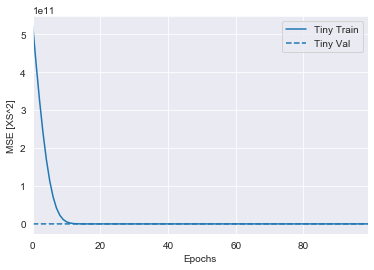

In [58]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=5)
plotter.plot(size_histories)
plt.ylim()
plt.ylabel('MSE [XS^2]')

<class 'numpy.ndarray'>
(223, 1)


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001E6FBC5BE08>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


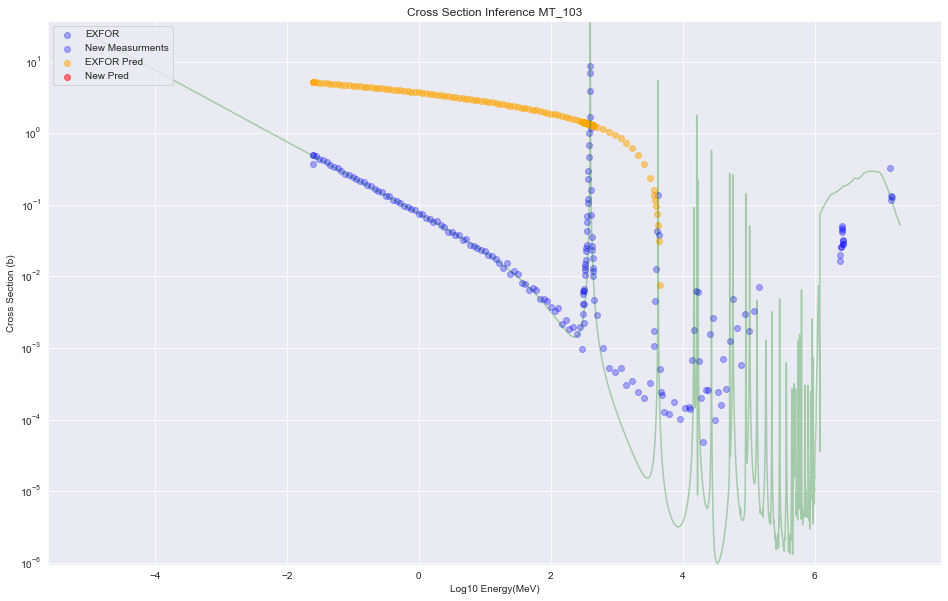

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:96: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001E6FAE4F808>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:103: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


[[-3.2762938]
 [-3.2762938]
 [-3.2962272]
 [-3.2962272]
 [-3.3078098]
 [-3.3078098]
 [-3.3191254]
 [-3.3191254]
 [-3.3374221]
 [-3.3374221]
 [-3.3374221]
 [-3.3374221]]


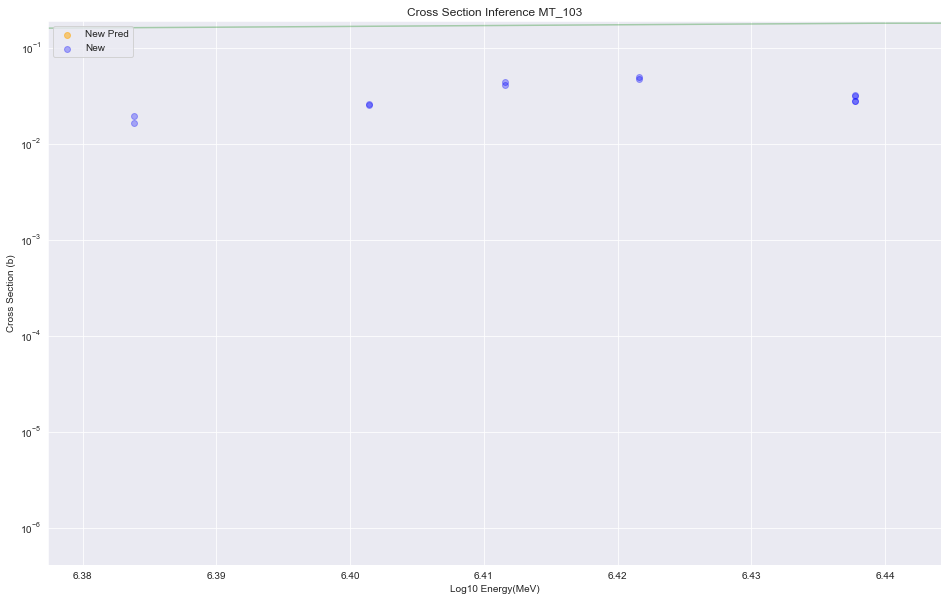

ENDF vs EXFOR:
The MSE is:  1.5254315355274362
The R2-Score is:  -0.8768535376442768
XS Tree vs EXFOR:
The MSE is:  6.671801371410371
The R2-Score is:  -7.20882072695702


C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
predicting_nuclear_xs("MT_103", 17, 35, size_histories['Tiny'].model, additional_data=new_data, endf=endf_all, E_min=0.14, E_max=16, N=50)

In [95]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=input_shape),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [96]:
%%time
# size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs=100)
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                944       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:463609709028.2745,  mae:101905.7344,  mse:463609724928.0000,  val_loss:1519.0971,  val_mae:9.7238,  val_mse:1519.0970,  
....................................................................................................Wall time: 1min 11s


In [97]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=input_shape),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)])

In [98]:
%%time
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium", df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                3776      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8673235722.4157,  mae:12449.7109,  mse:8673232896.0000,  val_loss:292941.8938,  val_mae:124.4862,  val_mse:292941.8750,  
....................................................................................................Wall time:

In [99]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=input_shape),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)])

In [100]:
%%time
# size_histories['large'] = compile_and_fit(large_model, "sizes/large", max_epochs=100)
size_histories['large'] = compile_and_fit(large_model, 'sizes/large', df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 818,689
Trainable params: 818,689
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:29447688476.3381,  mae:14807.9014,  mse:29447682048.0000,  val_loss:2972001.0052,  val_mae:388.080

In [73]:
# from bokeh.plotting import figure, output_file, show
# output_file("lines.html")

In [87]:
# # create a new plot with a title and axis labels
# p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# # add a line renderer with legend and line thickness
# p.line(np.linspace(0, 99, 100), pd.DataFrame(size_histories["large"].history)["mse"], legend="Temp.", line_width=2)

# # show the results
# show(p)

Text(0.5, 0, 'Epochs [Log Scale]')

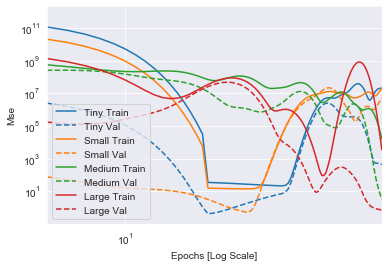

In [101]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

# Adding Regularization

In [107]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [108]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=input_shape),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               30208     
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 818,689
Trainable params: 818,689
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:45248972525.8734,  mae:18914.8438,  mse:45248970752.0000,  val_loss:176016147.1102,  val_mae:2972.

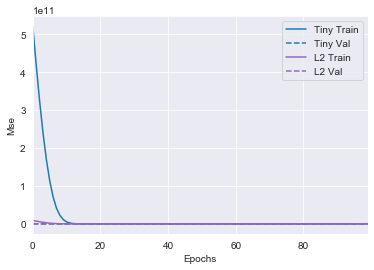

In [109]:
plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])

In [110]:
%%time
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               30208     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

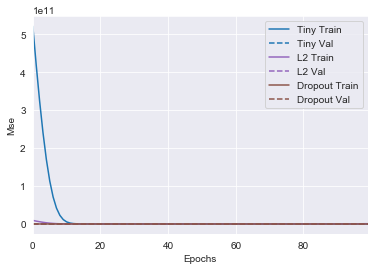

In [111]:
plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])

In [112]:
%%time
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined", df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               30208     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)              

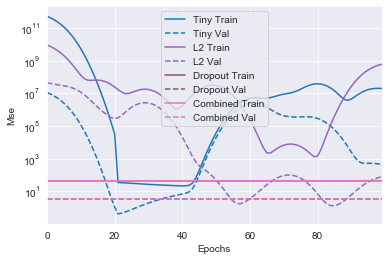

In [113]:
plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])
plt.yscale('log')

# Expanding L2 Model

In [216]:
activation_fn = "elu"
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=[len(x_train.keys())]),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

l2_model_exp = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 512)               67584     
_________________________________________________________________
dense_120 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_121 (Dense)            (None, 1000)              513000    
_________________________________________________________________
dense_122 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_123 (Dense)            (None, 512)               512512    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 512)             

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


.........................................
Epoch: 100, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
.............

In [223]:
plotter.plot(l2_model_exp)

AttributeError: 'History' object has no attribute 'items'

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000255FC463648>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


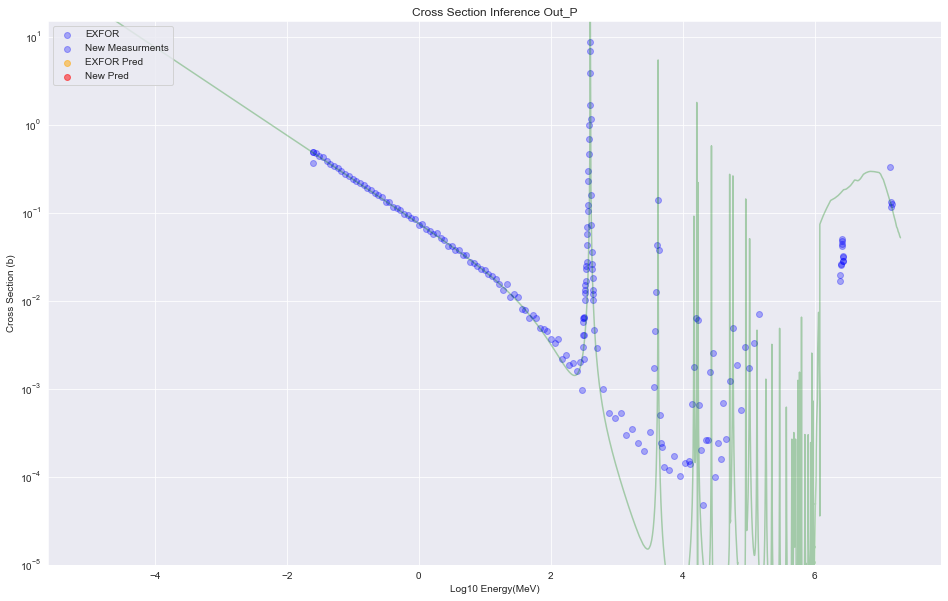

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000255FD995A08>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


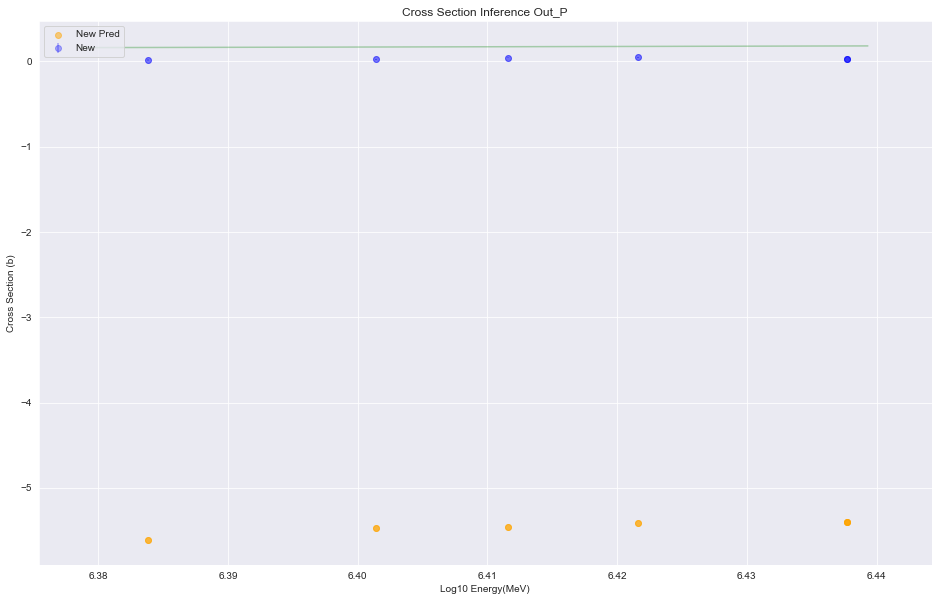

The MSE is:  57.67489321287504
The R2-Score is:  -69.9617736612562


In [88]:
predicting_nuclear_xs("Out_P", 17, 35, regularizer_histories['l2'].model, E_min=0.14, E_max=16)

# Other Strategy

In [46]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [40]:
mirrored_strategy = tf.distribute.MirroredStrategy()

def build_model():
    model = keras.Sequential([
        layers.Dense(250, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.RMSprop(0.01)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model


def build_gpu_model():
    with mirrored_strategy.scope():
        model = keras.Sequential([
            layers.Dense(150, activation='relu', input_shape=[len(x_train.keys())]),
            layers.Dense(250, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)])

        optimizer = tf.keras.optimizers.RMSprop(0.001)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
        return model

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [41]:
# model = build_model()
model = build_gpu_model()
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               19800     
_________________________________________________________________
dense_5 (Dense)              (None, 250)               37750     
_________________________________________________________________
dense_6 (Dense)       

In [47]:
with strategy.scope():
    model = keras.Sequential([
        layers.Dense(150, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(250, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [237]:
example_batch = x_train.values[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01175391],
       [-0.12772956],
       [-0.02639494],
       [-0.09360341],
       [ 0.00885992],
       [-0.17353778],
       [-0.08859062],
       [ 0.12745613],
       [-0.04629862],
       [ 0.01028054]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

In [318]:
example_batch = x_train.values[:10]
example_result = large_model.predict(example_batch)
example_result

array([[ 325.61108],
       [-148.68579],
       [2240.7556 ],
       [-578.2678 ],
       [ 138.15405],
       [1707.615  ],
       [ 563.96655],
       [3113.6619 ],
       [2050.1619 ],
       [1120.029  ]], dtype=float32)

# Training the Model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [48]:
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(
    x_train.values, y_train.values,
    batch_size=BATCH_SIZE, shuffle=True,
    epochs=EPOCHS, validation_split=0.2, verbose=1,
    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

# history = model.fit(
#     train_dataset,
#     epochs=EPOCHS, validation_data=val_dataset, verbose=1,
#     callbacks=[tfdocs.modeling.EpochDots()])

Train on 2901920 samples, validate on 725480 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
2885000/2901920 [============================>.] - ETA: 0s - loss: 356341206563.8958 - mae: 10315.1885 - mse: 356341153792.0000
Epoch: 0, loss:355940946036.8342,  mae:10357.3672,  mse:355940859904.0000,  val_loss:367352837936.4852,  val_mae:15887.8398,  val_mse:367352807424.0000,  
2901920/2901920 [==============================] - 17s 6us/sample - loss: 355940946036.8342 - mae: 10357.3672 - mse: 355940859904.0000 - val_loss: 367352837936.4852 - val_mae: 15887.8398 - val_mse: 367352807424.0000
Epoch 2/100
2901920/2901920 [==============================] - 10s 3us/sample - loss: 352079214548.1275 - ma

KeyboardInterrupt: 

In [239]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,4.242948e+10,1530.570190,4.242943e+10,2.113265e+10,1362.614014,2.113266e+10,95
96,4.244259e+10,1482.934570,4.244253e+10,2.487344e+10,1388.764771,2.487345e+10,96
97,3.968505e+10,1481.453369,3.968504e+10,2.306018e+10,1376.298096,2.306019e+10,97
98,4.138000e+10,1448.124268,4.137995e+10,1.991637e+10,1278.174805,1.991636e+10,98
99,4.304321e+10,1559.144775,4.304319e+10,3.451537e+10,1751.505493,3.451538e+10,99


In [240]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [XS]')

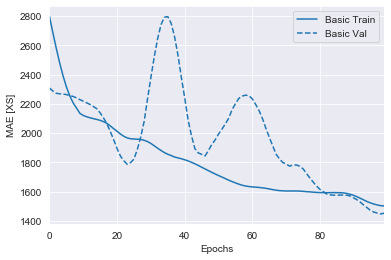

In [241]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim()
plt.ylabel('MAE [XS]')

Text(0, 0.5, 'MSE [XS^2]')

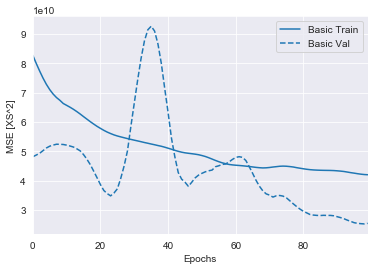

In [242]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim()
plt.ylabel('MSE [XS^2]')

In [233]:
loss, mae, mse = model.evaluate(x_test.values, y_test.values, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

906851/1 - 67s - loss: 24736169023.6159 - mae: 1594.6564 - mse: 49472081920.0000
Testing set Mean Abs Error: 1594.66 MPG


In [115]:
# DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("Out_P", 17, 35, model, E_min=0.14, E_max=16)

AttributeError: 'dict' object has no attribute 'predict'

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.